## Function Development - Weighting Scheme Project

Luke LeBel


The goal of this notebook is to read in forecast model data and verification data from a range of days and produce plots analyzing the performance of the models. 

### 1. Necessary imports

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [2]:
#Where the data files are located - will need to change
PATH = "./home/wxprediction_gmail_com/Data_ForecastContest/FTP/"

#### File naming conventions:

* archive_Fcst.csv, archive_ID.csv, archive_Sigma.csv - not sure 
* CFS.csv - looks like the most recent CFS forecast (2019-09-16)
* CFS_20190528.csv - forecast for a given date
* ECMWF.csv - looks like the most recent EC forecast (2019-09-12)
* ECMWF_20190528.csv - EC forecast for a given date
* wdd.daily.20190326.csv - a file containng verification

### 2. Important Functions (made)

Noting file structure - Important Columns:
1. model_date (contains initialization date)
2. fday (contains the day of the forecast (day 0, day 1, etc.)
3. verif_date (contains verification date)
4. value (contains HDD value)
5. normal_10y, normal_30y (climatology values)

note: both files have the same structure

note: both files contain separate sections for HDDs and CDDs

In [3]:
"""
This function reads in data from the file of ECMWF forecasts. 
It selects the forecast days of interest (for a given parameter) - default is CDDs.
It then returns the predicted value, the climo values for the forecast period, and the dates.
"""

def read_ecmwf(ec_file, param = "CDD"):
    isel_fdays = np.logical_and(ec_file['fday'] >= 16, ec_file['fday'] <= 20) #selecting the 16-20 day period
    isel_params = ec_file['param'] == param #Selecting the parameter of interest
    isel = np.logical_and(isel_fdays, isel_params)

    ec_values = ec_file['value'][isel]
    climo_10y = ec_file['normal_10y'][isel]
    climo_30y = ec_file['normal_30y'][isel]

    ec_predicted_value = np.sum(ec_values) #Predicted value = sum of CDDs/HDDs for forecast period
    cl10_predicted_value = np.sum(climo_10y)
    cl30_predicted_value = np.sum(climo_30y)
    dates = ec_file['verif_date'][isel] #selecting dates for the 16-20 period. These will be used to calculate observations
    
    return (ec_predicted_value, cl10_predicted_value, cl30_predicted_value, dates)

"""
This function reads in data from the file of CFS forecasts. 
It selects the forecast days of interest (for a given parameter) - default is CDDs.
It then returns the predicted value. It does not return anything else, as the EC function already does that.
"""

def read_cfs(cfs_file, param = "CDD"):
    isel_fdays = np.logical_and(cfs_file['fday'] >= 16, cfs_file['fday'] <= 20)
    isel_params = cfs_file['param'] == param
    isel = np.logical_and(isel_fdays, isel_params)

    cfs_values = cfs_file['value'][isel]

    cfs_predicted_value = np.sum(cfs_values)
    return cfs_predicted_value

"""
This function reads in observations corresponding to a series of dates. 
It accepts a list of dates corresponding the forecast days of interest.
It then formats the dates to the file convention, opens the file for each date, and collects the value of a given parameter.
It then returns the observed value.
"""

def read_obs(dates, param = "CDD"):
    dates = np.array(dates)

    verif_values = []

    i = 0
    while i < len(dates):
        d_str = dates[i] #Obtaining the first date in the period
        
        #Here, we open the file corresponding to the following date (we can then look back one day in this file to get verification)
        d_dt = datetime.strptime(dates[i],"%Y-%m-%d") 
        d_dt = d_dt + timedelta(days = 1)
        f_string = datetime.strftime(d_dt, "%Y%m%d")
        verif_file = pd.read_csv(PATH+"wdd.daily."+f_string+".csv")
        
        #Selecting the value corresponding to the date and parameter of interest
        isel = np.logical_and(verif_file['DATE'] == d_str, verif_file['PARAM'] == param)
        verif_values.append(verif_file['VALUE'][isel].values)
        i = i+1
    
    #Verification = sum over all verification dates
    verif_value = np.sum(verif_values)
    
    return verif_value

### 3. Looping through all forecast dates

The start and end variables here can be adjusted to a different period of interest. This section of code loops through all of the dates where ECMWF and CFS data both exist (valid_dates selects only days where they both exist), and calls the above functions to determine the forecast and verification values. The dates (stored in date_list) correspond to the dates the forecasts were issued. 

In [4]:
#These lists will hold the forecast and verification values
cfs_vals = []
ecmwf_vals = []
c10_vals = []
c30_vals = []
verif_vals = []
date_list = []

#These values can be adjusted to change the period of interest
start = datetime(2019, 6, 2)
end = datetime(2019, 8, 27)
delta = timedelta(days=1)

#This loop loops through all valid dates and stores the results into the lists above
d = start
diff = 0
valid_dates = set([0, 3])
while d <= end:
    if d.weekday() in valid_dates:
        
        date_list.append(d)
        
        f_string = datetime.strftime(d, "%Y%m%d")
        
        #loading ECMWF file
        ec_file = pd.read_csv(PATH+"ECMWF_"+f_string+".csv")
        cfs_file = pd.read_csv(PATH+"CFS_"+f_string+".csv")
        ec_val, c10_val, c30_val, dates = read_ecmwf(ec_file)
        cfs_val = read_cfs(cfs_file)
        verif_val = read_obs(dates)
        
        cfs_vals.append(cfs_val)
        ecmwf_vals.append(ec_val)
        c10_vals.append(c10_val)
        c30_vals.append(c30_val)
        verif_vals.append(verif_val)
        
    d += delta

### 4. Storing Data + Data Analysis

This code block stores the data into a dataframe that is easy to use, and then begins preliminary data analysis

In [5]:
data = {'CFS':cfs_vals, 'ECMWF':ecmwf_vals, '10y_climo':c10_vals, '30y_climo':c30_vals, 'Verif':verif_vals}

master_dataframe = pd.DataFrame(data, index = date_list) #Contains all of the data

#### 4.1. Plotting performance vs. time

/kt11/ktyle/anaconda3_201903/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


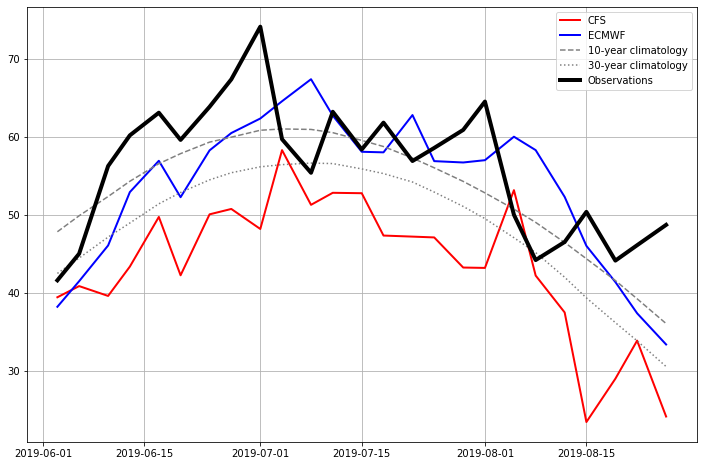

In [6]:
plt.figure(figsize = (12,8))

plt.plot(master_dataframe['CFS'], color = 'red', linewidth = 2.0, label = 'CFS')
plt.plot(master_dataframe['ECMWF'], color = 'blue', linewidth = 2.0, label = 'ECMWF')
plt.plot(master_dataframe['10y_climo'], '--', color = 'gray', label = '10-year climatology')
plt.plot(master_dataframe['30y_climo'], ':', color = 'gray', label = '30-year climatology')
plt.plot(master_dataframe['Verif'], color = 'black', linewidth = 4.0, label = 'Observations')

plt.grid()
plt.legend()
plt.show()

#### 4.2. Scatterplots of model anomalies and verification anomalies

This scatterplot displays the anomalies predicted by the models on the x-axis, and the verifying anomalies on the y-axis. Each dot therefore represents one model forecast/verification pair. If forecasts were perfect, they would lie along the black line (y = x), indicating that the model forecast anomaly is equal to the verifying anomaly for all forecast dates.

The results here indicate that both the CFS and ECMWF performed very poorly during the current dates of interest. This is confirmed by the "anomaly correlations" printed below the plot. 

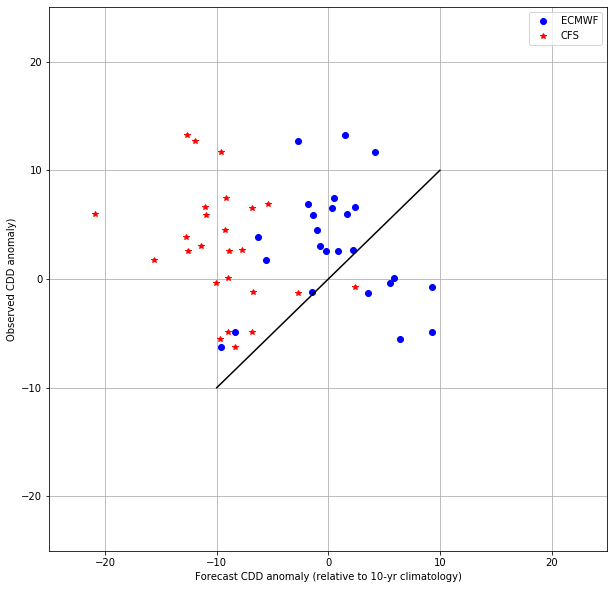

ECMWF/Verification Anomaly Correlation: -0.03
CFS/Verification Anomaly Correlation: -0.33


In [7]:
plt.figure(figsize = (10,10))

plt.plot(master_dataframe['ECMWF']-master_dataframe['10y_climo'], master_dataframe['Verif']-master_dataframe['10y_climo'], 'o', color = 'blue', label = 'ECMWF')
plt.plot(master_dataframe['CFS']-master_dataframe['10y_climo'], master_dataframe['Verif']-master_dataframe['10y_climo'], '*', color = 'red', label = 'CFS')
plt.plot([-10,10], [-10,10], color = 'black')

plt.xlim(-25,25)
plt.ylim(-25,25)

plt.ylabel('Observed CDD anomaly)')
plt.xlabel('Forecast CDD anomaly (relative to 10-yr climatology)')

plt.grid()
plt.legend()
plt.show()

ec_corr = pearsonr(master_dataframe['ECMWF']-master_dataframe['10y_climo'], master_dataframe['Verif']-master_dataframe['10y_climo'])[0]
cfs_corr = pearsonr(master_dataframe['CFS']-master_dataframe['10y_climo'], master_dataframe['Verif']-master_dataframe['10y_climo'])[0]
print("ECMWF/Verification Anomaly Correlation: %.2f" % ec_corr)
print("CFS/Verification Anomaly Correlation: %.2f" % cfs_corr)


#### 4.3. Anomalies by date

The following two plots further explore model performance. 
1. The first plot shows the forecast and verification anomaly, relative to the 10-year climatology, by date. If forecast were perfect (or skillfull), all of the lines should overlap. We can see this is not the case.
2. The second plot shows the forecast and verification anomaly, relative to the 10-year climatology AND corrected for any persistent model biases, by date. This attempts a pseudo-bias correction that better isolates how the model is performing. Again, we can see that th emodels in general do not perform well. 

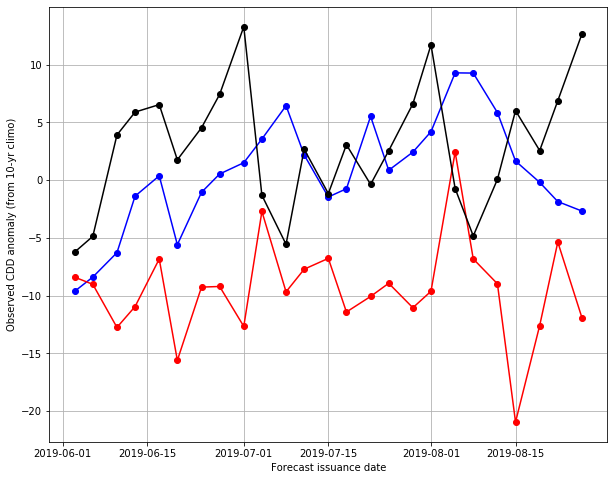

In [8]:
plt.figure(figsize = (10,8))

plt.plot(master_dataframe['ECMWF']-master_dataframe['10y_climo'], '-o', color = 'blue')
plt.plot(master_dataframe['CFS']-master_dataframe['10y_climo'], '-o', color = 'red')
plt.plot(master_dataframe['Verif']-master_dataframe['10y_climo'], '-o', color = 'black')
#plt.plot([-10,10], [-10,10], color = 'black')

plt.ylabel('Observed CDD anomaly (from 10-yr climo)')
plt.xlabel('Forecast issuance date')

plt.grid()
plt.show()

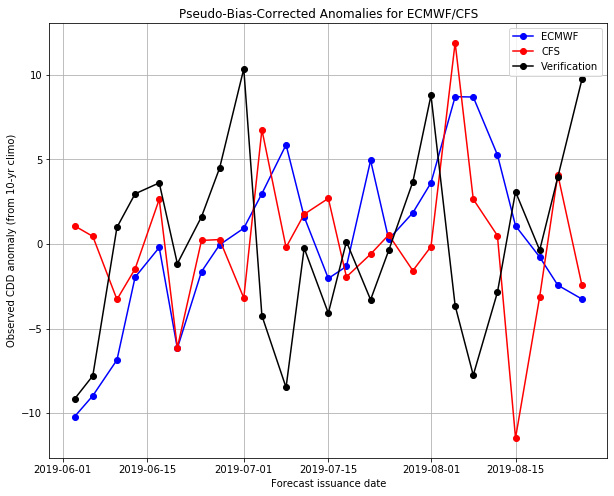

In [9]:
plt.figure(figsize = (10,8))

ec_anom = master_dataframe['ECMWF']-master_dataframe['10y_climo']
cfs_anom = master_dataframe['CFS']-master_dataframe['10y_climo']
verif_anom = master_dataframe['Verif']-master_dataframe['10y_climo']

plt.plot(ec_anom - np.mean(ec_anom), '-o', color = 'blue', label = "ECMWF")
plt.plot(cfs_anom - np.mean(cfs_anom), '-o', color = 'red', label = "CFS")
plt.plot(verif_anom - np.mean(verif_anom), '-o', color = 'black', label = "Verification")

plt.ylabel('Observed CDD anomaly (from 10-yr climo)')
plt.xlabel('Forecast issuance date')

plt.title("Pseudo-Bias-Corrected Anomalies for ECMWF/CFS")
plt.legend()
plt.grid()
plt.show()